In [58]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [59]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
all_results = []

def train_data(X, y, shapeX, shapeY, nsize1, nsize2, lr, epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, shapeY), dtype=torch.float32) #1 ->4
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, shapeY), dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    class RegressionModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
            nn.Linear(shapeX, nsize1),
            nn.ReLU(),
            nn.Linear(nsize1, nsize2), 
            nn.ReLU(),
            nn.Linear(nsize2, shapeY)  
        )

        def forward(self, x):
            return self.net(x)

    model = RegressionModel()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_values = []

    for epochs in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        loss_values.append(epoch_loss)


    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = criterion(predictions, y_test_tensor)
        mae = torch.mean(torch.abs(predictions - y_test_tensor))
        r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
        print(f"MSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
        
    return loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2

In [62]:
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

In [ ]:
def plot_compare(predictions, y_test_tensor, tittle, targets):

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):
        if i >= len(targets):
            break
        print(f"Plotting {targets[i]}: {i+1}/{len(targets)}")
        # Ensure the index does not exceed the number of targets
        actual = y_test_tensor[:, i].numpy()
        pred = predictions[:, i].numpy()
        ax.plot(actual, label='Actual', color='blue')
        ax.plot(pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{targets[i]}: Actual vs Predicted')
        #ax.set_xlabel('Sample Index')
        ax.set_ylabel(targets[i])
        ax.grid(True)
        ax.legend()

    fig.suptitle(f'Actual vs Predicted {tittle}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [64]:
def evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=5, features=''):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
        mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
        

    y_true = y_test_tensor.numpy().flatten()
    y_pred = predictions.numpy().flatten()

    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': y_pred - y_true
    })

    print(f"Evaluation Results:\n - MSE: {mse:.4f}\n - MAE: {mae:.4f} \n - R2: {r2.item():.4f}")
    print("\nExample predictions:")
    print(results_df.head(n))
    results = []
    results.append({
        'Model': features, 
        'MSE': mse,
        'MAE': mae,
        'R2': r2.item()
    })

    return pd.DataFrame(results)

In [65]:
target_names = ['Al2O3', 'Fe2O3', 'CS-C', 'Carbono']
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.drop(columns=['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7'])
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, 77, 4, 64, 32, 0.002, 200)

MSE: 0.3272, MAE: 0.3346 R2: 0.9972


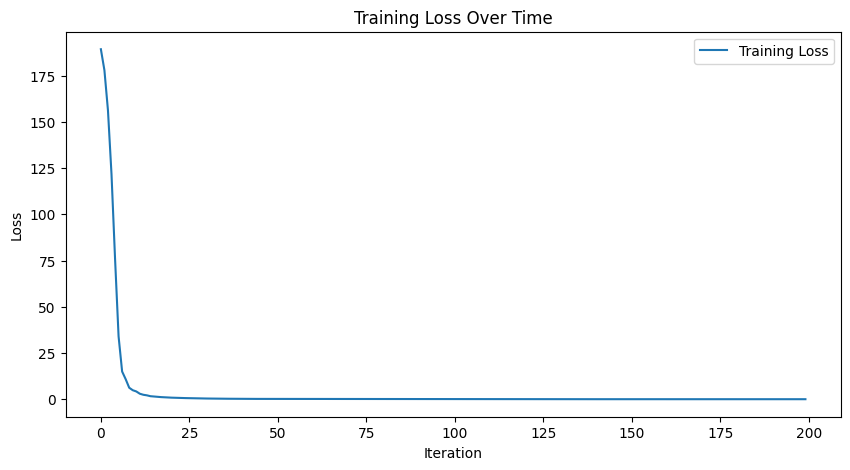

In [66]:
plot_loss(loss_values)

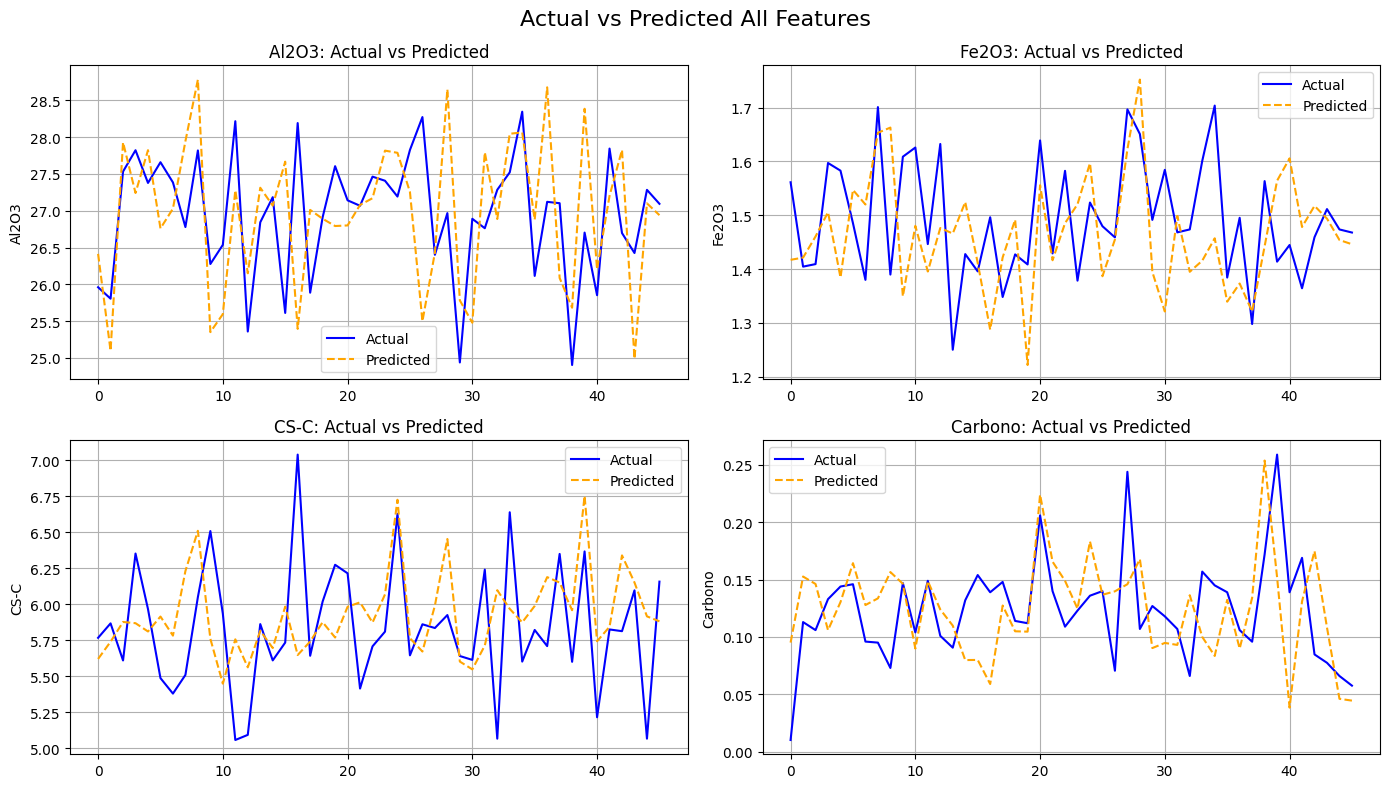

In [67]:
plot_compare(predictions, y_test_tensor, 'All Features', target_names)

In [68]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features = 'All Features')
all_results.append(results)

Evaluation Results:
 - MSE: 0.3272
 - MAE: 0.3346 
 - R2: 0.9972

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.414127  0.453440
1   1.561302   1.417296 -0.144006
2   5.767001   5.620146 -0.146855
3   0.010200   0.095125  0.084925
4  25.805275  25.096737 -0.708538
5   1.404642   1.421387  0.016745
6   5.867491   5.739983 -0.127508
7   0.113000   0.152693  0.039693
8  27.533176  27.930431  0.397255
9   1.409339   1.460664  0.051325


## NN for the first 3 raw materials


In [69]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.iloc[:, :33]

X.shape, y.shape

((230, 33), (230, 4))

In [70]:
y = data[['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']]
X = data.iloc[:, :33]

loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, 33, 4, 64, 32, 0.002, 200)  #X, y, shapeX, shapey

MSE: 1.2108, MAE: 0.5646 R2: 0.9896


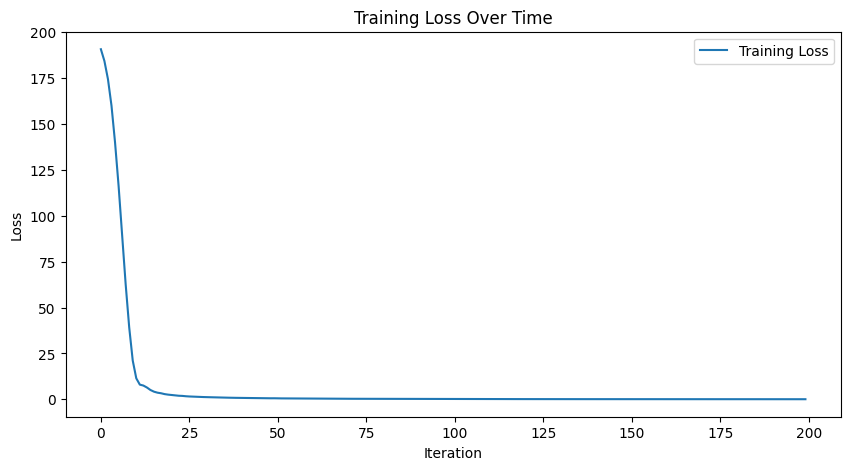

In [71]:
plot_loss(loss_values)

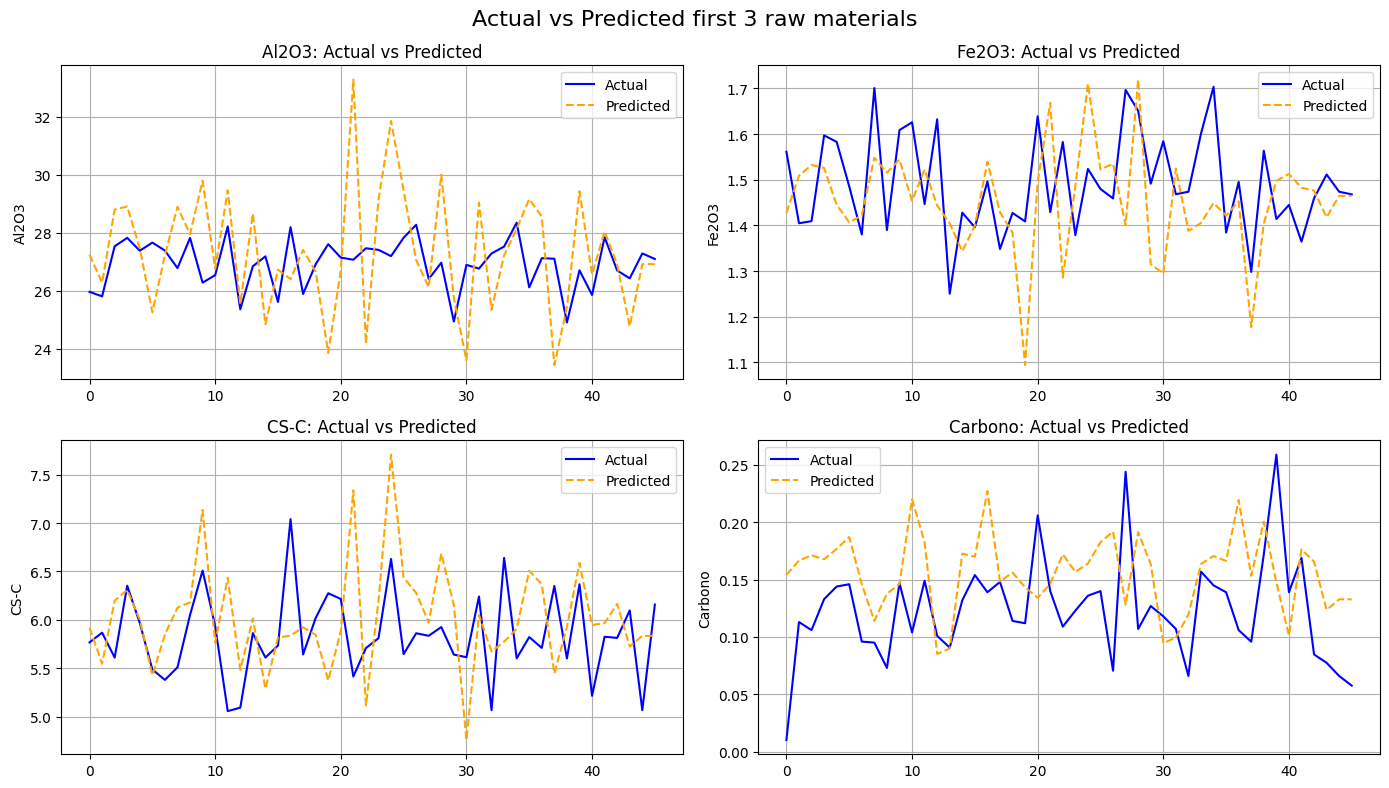

In [72]:
plot_compare(predictions, y_test_tensor, 'first 3 raw materials', target_names)

In [73]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='first 3 raw materials')
all_results.append(results)

Evaluation Results:
 - MSE: 1.2108
 - MAE: 0.5646 
 - R2: 0.9896

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.244749  1.284061
1   1.561302   1.427463 -0.133839
2   5.767001   5.918907  0.151906
3   0.010200   0.154204  0.144004
4  25.805275  26.275459  0.470184
5   1.404642   1.508739  0.104097
6   5.867491   5.546627 -0.320864
7   0.113000   0.166622  0.053622
8  27.533176  28.801298  1.268122
9   1.409339   1.532224  0.122885


## Predicting Al, Fe and Carbon using those features and their use %

In [74]:
y = data[['Al2O3.7', 'Fe2O3.7', 'Carbono.7']]
X = data.filter(regex='^Al2O3|^Fe2O3|^Carbono|^%')
X = X.drop(columns=['Al2O3.7', 'Fe2O3.7', 'Carbono.7'])

In [75]:
X.shape, y.shape

((230, 28), (230, 3))

In [76]:
loss_values, predictions, y_test_tensor, model, y_train_tensor, X_test_tensor, r2 = train_data(X, y, 28, 3, 64, 32, 0.002, 200)


MSE: 0.2342, MAE: 0.2640 R2: 0.9985


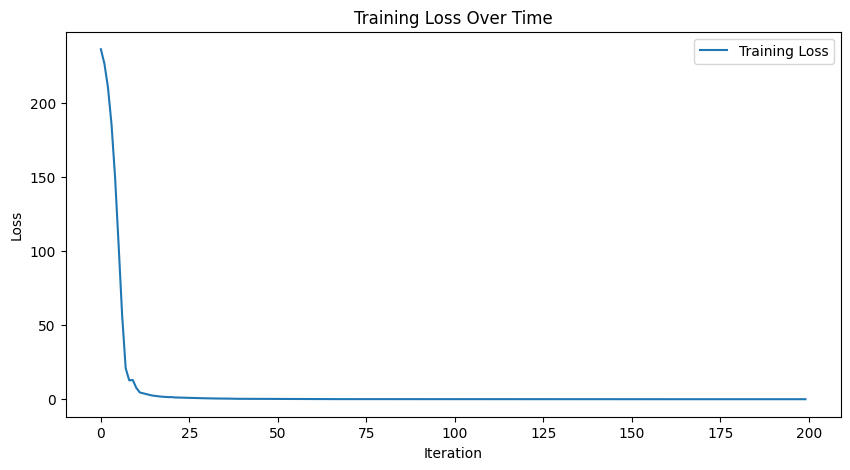

In [77]:
plot_loss(loss_values)

IndexError: index 3 is out of bounds for dimension 1 with size 3

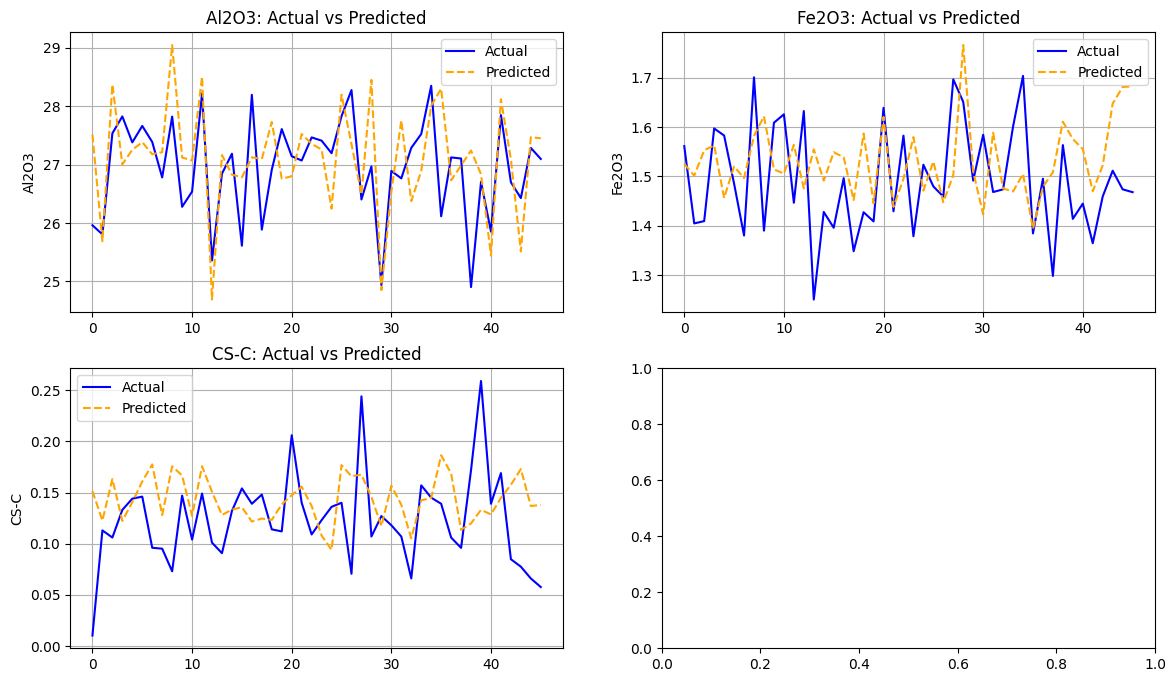

In [78]:
plot_compare(predictions, y_test_tensor, 'Al2O3, Fe2O3 and Carbono', target_names)

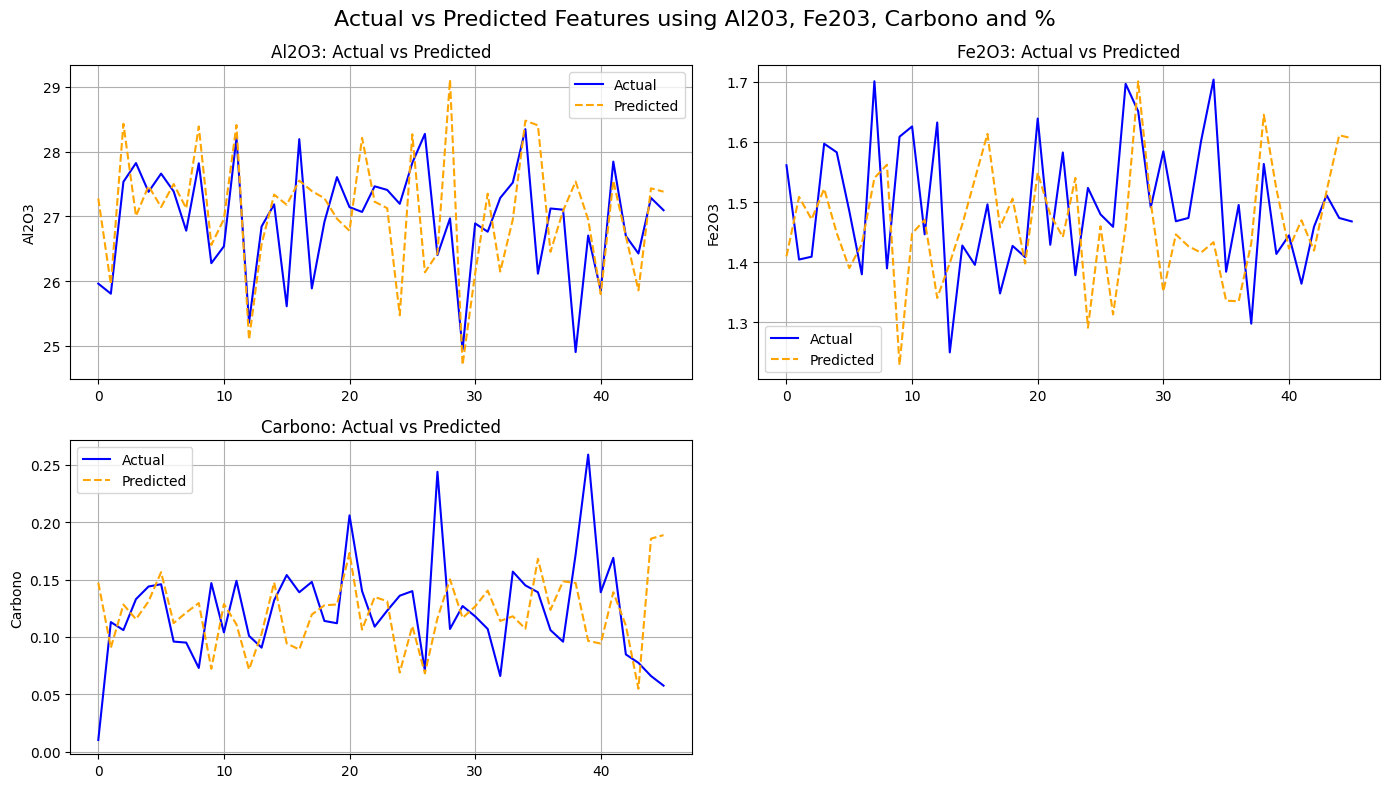

In [ ]:
target_names = ['Al2O3', 'Fe2O3','Carbono']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axs.ravel()):
    if i >= len(target_names):
        break
    actual = y_test_tensor[:, i].numpy()
    pred = predictions[:, i].numpy()
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', linestyle='--', color='orange')
    ax.set_title(f'{target_names[i]}: Actual vs Predicted')
    #ax.set_xlabel('Sample Index')
    ax.set_ylabel(target_names[i])
    ax.grid(True)
    ax.legend()

fig.suptitle('Actual vs Predicted Features using Al203, Fe203, Carbono and %', fontsize=16)


for i in range(len(target_names), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

In [ ]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203, Fe203, Carbono and %')
all_results.append(results)

Evaluation Results:
 - MSE: 0.2965
 - MAE: 0.2721 
 - R2: 0.9981

Example predictions:
      Actual  Predicted     Error
0  25.960688  27.275702  1.315014
1   1.561302   1.410000 -0.151302
2   0.010200   0.147338  0.137138
3  25.805275  25.949549  0.144274
4   1.404642   1.508708  0.104066
5   0.113000   0.090708 -0.022292
6  27.533176  28.429773  0.896597
7   1.409339   1.471449  0.062110
8   0.106000   0.128260  0.022260
9  27.822983  27.004948 -0.818035


## Direct Features Prediction (unsure se devia usar feature + percentagem) mas acredito que faz mais sentido ter percentagem otherwise não faz sentido só dar quantidade de Al

In [ ]:
y = data[['Al2O3.7']]
X = data.filter(regex='^Al2O3')
X = X.drop(columns=['Al2O3.7'])

In [ ]:
X.shape, y.shape

((230, 7), (230, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.net(x)

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

loss_values = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_values.append(epoch_loss)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    r2 = 1 - (torch.sum((predictions - y_test_tensor) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2))
    print(f"\nMSE: {mse.item():.4f}, MAE: {mae.item():.4f}", f"R2: {r2.item():.4f}")
    



MSE: 0.6573, MAE: 0.6199 R2: 0.0593


In [ ]:
plot_loss()

TypeError: plot_loss() missing 1 required positional argument: 'loss_values'

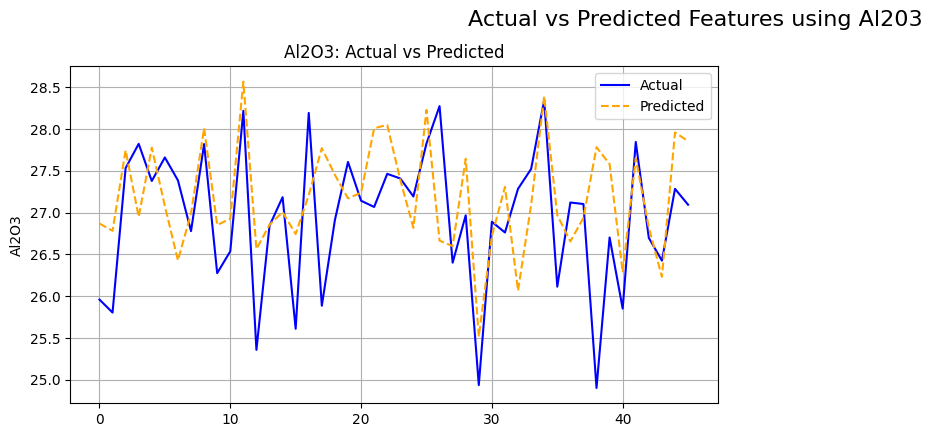

In [ ]:
target_names = ['Al2O3']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axs.ravel()):
    if i >= len(target_names):
        break
    actual = y_test_tensor[:, i].numpy()
    pred = predictions[:, i].numpy()
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', linestyle='--', color='orange')
    ax.set_title(f'{target_names[i]}: Actual vs Predicted')
    #ax.set_xlabel('Sample Index')
    ax.set_ylabel(target_names[i])
    ax.grid(True)
    ax.legend()

fig.suptitle('Actual vs Predicted Features using Al203', fontsize=16)


for i in range(len(target_names), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

In [ ]:
results = evaluate_with_examples(model, X_test_tensor, y_test_tensor, n=10, features='Al203')
all_results.append(results)

Evaluation Results:
 - MSE: 0.6685
 - MAE: 0.6197 
 - R2: 0.0432

Example predictions:
      Actual  Predicted     Error
0  25.960688  26.869209  0.908522
1  25.805275  26.783094  0.977819
2  27.533176  27.746532  0.213356
3  27.822983  26.949072 -0.873911
4  27.378498  27.776896  0.398397
5  27.660057  27.078003 -0.582054
6  27.385485  26.429497 -0.955988
7  26.778746  26.992081  0.213335
8  27.819937  28.010057  0.190121
9  26.276518  26.852324  0.575806


## Final results

In [ ]:
final_results_df = pd.concat(all_results, ignore_index=True)


print("\nFinal Results:")
from IPython.display import display
display(final_results_df)


Final Results:


,Model,MSE,MAE,R2
0,All Features,0.258643,0.316158,0.997786
1,first 3 raw materials,1.600484,0.610479,0.986303
2,"Al203, Fe203, Carbono and %",0.280904,0.277886,0.998156
3,Al203,0.668549,0.619727,0.043168


In [ ]:
final_results_df = final_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nSorted Final Results:")
display(final_results_df)


Sorted Final Results:


,Model,MSE,MAE,R2
0,"Al203, Fe203, Carbono and %",0.280904,0.277886,0.998156
1,All Features,0.258643,0.316158,0.997786
2,first 3 raw materials,1.600484,0.610479,0.986303
3,Al203,0.668549,0.619727,0.043168
